In [0]:
!nvidia-smi

Fri Oct  4 09:45:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    71W / 149W |    359MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# CNN 실습

문의사항 이메일 계산지능 연구실 염상우 dkdwm5135@gmail.com

# Convolution Arithmetic
|w/o stride| w/ stride|
|:---------:|:---------:|
|kernel size: 3, stride: **1**, padding: 1|kernel size: 3, stride: **2**, padding: 1|
|![](http://deeplearning.net/software/theano/_images/same_padding_no_strides.gif)|![](http://deeplearning.net/software/theano/_images/padding_strides.gif)|


In [0]:
import torchvision
from torchvision import datasets as D
from torchvision import transforms as T

import torch
from torch import nn
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook
from sklearn import metrics

%matplotlib inline
from matplotlib import pyplot as plt

In [0]:
device = torch.device('cpu')  # cpu 사용
device = torch.device('cuda') # gpu 사용

# Convolution Arguments in PyTorch
### torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, ...)

|인자        |설명                                   |
|-----------:|---------------------------------------|
|in_channels |레이어 입력의 채널 사이즈 (필터의 높이)|
|out_channels|레이어 출력의 채널 사이즈 (필터의 개수)|
|kernel_size |필터의 가로, 세로 크기 (파란색 위 회색)|
|stride      |필터 연산 시 건너뛰는 픽셀 개수        |
|padding     |패딩의 크기 (파란색 점선)              |

# Rectifier Linear Unit (ReLU)

y = ReLU(x) = max(0, x)

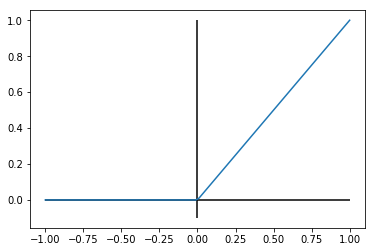

In [0]:
import numpy as np
x = np.linspace(-1, 1, 100)
y = np.maximum(0, x)
plt.plot(x, y)
plt.vlines(0, -0.1, 1)
plt.hlines(0, -1, 1)
plt.show()

# Pooling layer

![Pooling layer](http://cs231n.github.io/assets/cnn/pool.jpeg)

# 모델 만들기

- 모델의 정보를 출력하기 위해서 새로 만드는 모델 클래스는 Model이라는 클래스를 상속한다.
- 기본 적인 뼈대 모델은 다음과 같다.
  - convolutional layer 세 개
  - ReLU 세 개
  - Average pooling layer 한 개
  - Fully connected (Linear) layer 한 개

| layer 이름 | output feature size |
|:----------:|:-------------------:|
|input       | b x 1 x 32 x 32     |
|conv1       | b x 16 x 16 x 16    |
|conv2       | b x 32 x 8 x 8      |
|conv3       | b x 64 x 4 x 4      |

<center>(b는 batch size) </center>

- 성능을 올리기 위해서 모델을 변경할 때는 다음과 같은 방법을 추천한다.
  - 뼈대 모델 중간 중간에 convolutional layer 추가 하기.
  - in/out channel 개수 변경 해보기

In [0]:
class Model(nn.Module):
  def __repr__(self):
    txt = super().__repr__() + '\n\n'
    txt += 'Number of parameters\n'
    total = 0
    for name, p in self.named_parameters():
      txt += name + f':\t{p.numel()}\n'
      total += p.numel()
    txt += f'Total:\t{total}'
    return txt

class MNISTCNN(Model):
  def __init__(self, num_conv_layers=0):
    super(MNISTCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
    self.rectifier1 = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.rectifier2 = nn.ReLU(inplace=True)

    self.conv3 = nn.Conv2d(32, 64, 3, 2, 1)
    self.rectifier3 = nn.ReLU(inplace=True)

    self.avgpool = nn.AvgPool2d(4)
    self.fc = nn.Linear(64, 10)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.rectifier1(x)

    x = self.conv2(x)
    x = self.rectifier2(x)
    
    x = self.conv3(x)
    x = self.rectifier3(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [0]:
model = MNISTCNN()
print(model)

MNISTCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rectifier1): ReLU(inplace=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rectifier2): ReLU(inplace=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rectifier3): ReLU(inplace=True)
  (avgpool): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

Number of parameters
conv1.weight:	144
conv1.bias:	16
conv2.weight:	4608
conv2.bias:	32
conv3.weight:	18432
conv3.bias:	64
fc.weight:	640
fc.bias:	10
Total:	23946


In [0]:
def process_batch(batch):
  x, y = batch
  return x.to(device), y.to(device)

def train(epoch, dataloader, model, optimizer, criterion):
  model.train()
  pbar = tqdm_notebook(total=len(dataloader))
  losses = []
  for i, batch in enumerate(dataloader):
    optimizer.zero_grad()

    x, y = process_batch(batch)
    out = model(x)

    loss = criterion(out, y)
    loss.backward()
    optimizer.step()

    if (i % 100) == 0:
      print(f'Epoch: {epoch}, iter: [{i:4} / {len(dataloader):4}]'
            f'loss: {loss.item():.4f}')

    pbar.set_description(f'loss: {loss.item():.4f}')
    pbar.update()
    losses.append(loss.item())
  pbar.close()
  
  return losses

@torch.no_grad()
def test(epoch, dataloader, model):
  model.eval()
  losses = []
  labels = []
  preds = []
  for i, batch in enumerate(dataloader):
    x, y = process_batch(batch)
    out = model(x)
    loss = criterion(out, y)
    losses.append(loss.item())

    pred = out.argmax(1)
    preds.extend(pred.tolist())
    labels.extend(y.tolist())
  
  average_loss = sum(losses) / len(losses)
  accuracy = metrics.accuracy_score(labels, preds)
  print(f'loss: {average_loss:.3f} accuracy: {accuracy:.3f}')
  return average_loss, accuracy

In [0]:
max_epochs = 15
batch_size = 128

In [0]:
train_dataset = D.MNIST(
    root='.', train=True, transform=T.ToTensor(), download=True)
test_dataset = D.MNIST(
    root='.', train=False, transform=T.ToTensor(), download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
model = model.to(device)

In [0]:
training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []
pbar = tqdm_notebook(total=max_epochs, desc='Epoch: 0')
for e in range(1, max_epochs+1):
  training_loss = train(e, train_loader, model, optimizer, criterion)

  print(f'\nEpoch: {e} training result')
  _, training_accuracy = test(e, train_loader, model)
  
  print(f'\nEpoch: {e} test result')
  test_loss, test_accuracy = test(e, test_loader, model)
  
  pbar.set_description(
      f'Epoch {e} lr: {optimizer.param_groups[0]["lr"]:.3f}')
  pbar.update()

  training_losses.extend(training_loss)
  training_accuracies.append(training_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
pbar.close()

Epoch: 1, iter: [   0 /  469]loss: 2.2935
Epoch: 1, iter: [ 100 /  469]loss: 1.5540
Epoch: 1, iter: [ 200 /  469]loss: 0.9921
Epoch: 1, iter: [ 300 /  469]loss: 0.8453
Epoch: 1, iter: [ 400 /  469]loss: 0.6957

Epoch: 1 training result
loss: 0.509 accuracy: 0.851

Epoch: 1 test result
loss: 0.504 accuracy: 0.853


Epoch: 2, iter: [   0 /  469]loss: 0.4159
Epoch: 2, iter: [ 100 /  469]loss: 0.7278
Epoch: 2, iter: [ 200 /  469]loss: 0.3954
Epoch: 2, iter: [ 300 /  469]loss: 0.4628
Epoch: 2, iter: [ 400 /  469]loss: 0.3915

Epoch: 2 training result
loss: 0.343 accuracy: 0.897

Epoch: 2 test result
loss: 0.323 accuracy: 0.901


Epoch: 3, iter: [   0 /  469]loss: 0.2868
Epoch: 3, iter: [ 100 /  469]loss: 0.3150
Epoch: 3, iter: [ 200 /  469]loss: 0.3360
Epoch: 3, iter: [ 300 /  469]loss: 0.3080
Epoch: 3, iter: [ 400 /  469]loss: 0.2574

Epoch: 3 training result
loss: 0.255 accuracy: 0.924

Epoch: 3 test result
loss: 0.243 accuracy: 0.928


Epoch: 4, iter: [   0 /  469]loss: 0.1433
Epoch: 4, iter: [ 100 /  469]loss: 0.4007
Epoch: 4, iter: [ 200 /  469]loss: 0.1837
Epoch: 4, iter: [ 300 /  469]loss: 0.3121
Epoch: 4, iter: [ 400 /  469]loss: 0.2192

Epoch: 4 training result
loss: 0.201 accuracy: 0.942

Epoch: 4 test result
loss: 0.194 accuracy: 0.946


Epoch: 5, iter: [   0 /  469]loss: 0.1969
Epoch: 5, iter: [ 100 /  469]loss: 0.3192
Epoch: 5, iter: [ 200 /  469]loss: 0.1795
Epoch: 5, iter: [ 300 /  469]loss: 0.3050
Epoch: 5, iter: [ 400 /  469]loss: 0.1651

Epoch: 5 training result
loss: 0.177 accuracy: 0.946

Epoch: 5 test result
loss: 0.172 accuracy: 0.949


Epoch: 6, iter: [   0 /  469]loss: 0.2866
Epoch: 6, iter: [ 100 /  469]loss: 0.2249
Epoch: 6, iter: [ 200 /  469]loss: 0.2304
Epoch: 6, iter: [ 300 /  469]loss: 0.2144
Epoch: 6, iter: [ 400 /  469]loss: 0.2016

Epoch: 6 training result
loss: 0.180 accuracy: 0.946

Epoch: 6 test result
loss: 0.173 accuracy: 0.947


Epoch: 7, iter: [   0 /  469]loss: 0.1737
Epoch: 7, iter: [ 100 /  469]loss: 0.1706
Epoch: 7, iter: [ 200 /  469]loss: 0.1999
Epoch: 7, iter: [ 300 /  469]loss: 0.1734
Epoch: 7, iter: [ 400 /  469]loss: 0.2012

Epoch: 7 training result
loss: 0.133 accuracy: 0.960

Epoch: 7 test result
loss: 0.126 accuracy: 0.960


Epoch: 8, iter: [   0 /  469]loss: 0.1184
Epoch: 8, iter: [ 100 /  469]loss: 0.1394
Epoch: 8, iter: [ 200 /  469]loss: 0.2040
Epoch: 8, iter: [ 300 /  469]loss: 0.1434
Epoch: 8, iter: [ 400 /  469]loss: 0.0823

Epoch: 8 training result
loss: 0.135 accuracy: 0.959

Epoch: 8 test result
loss: 0.134 accuracy: 0.961


Epoch: 9, iter: [   0 /  469]loss: 0.1622
Epoch: 9, iter: [ 100 /  469]loss: 0.0939
Epoch: 9, iter: [ 200 /  469]loss: 0.2281
Epoch: 9, iter: [ 300 /  469]loss: 0.2380
Epoch: 9, iter: [ 400 /  469]loss: 0.0921

Epoch: 9 training result
loss: 0.124 accuracy: 0.962

Epoch: 9 test result
loss: 0.128 accuracy: 0.963


Epoch: 10, iter: [   0 /  469]loss: 0.1133
Epoch: 10, iter: [ 100 /  469]loss: 0.2195
Epoch: 10, iter: [ 200 /  469]loss: 0.1393
Epoch: 10, iter: [ 300 /  469]loss: 0.1639
Epoch: 10, iter: [ 400 /  469]loss: 0.1118

Epoch: 10 training result
loss: 0.111 accuracy: 0.966

Epoch: 10 test result
loss: 0.109 accuracy: 0.966


Epoch: 11, iter: [   0 /  469]loss: 0.0553
Epoch: 11, iter: [ 100 /  469]loss: 0.0770
Epoch: 11, iter: [ 200 /  469]loss: 0.0669
Epoch: 11, iter: [ 300 /  469]loss: 0.1165
Epoch: 11, iter: [ 400 /  469]loss: 0.1608

Epoch: 11 training result
loss: 0.092 accuracy: 0.973

Epoch: 11 test result
loss: 0.097 accuracy: 0.970


Epoch: 12, iter: [   0 /  469]loss: 0.0842
Epoch: 12, iter: [ 100 /  469]loss: 0.0903
Epoch: 12, iter: [ 200 /  469]loss: 0.0656
Epoch: 12, iter: [ 300 /  469]loss: 0.0746
Epoch: 12, iter: [ 400 /  469]loss: 0.1508

Epoch: 12 training result
loss: 0.091 accuracy: 0.972

Epoch: 12 test result
loss: 0.099 accuracy: 0.969


Epoch: 13, iter: [   0 /  469]loss: 0.1905
Epoch: 13, iter: [ 100 /  469]loss: 0.0685
Epoch: 13, iter: [ 200 /  469]loss: 0.0555
Epoch: 13, iter: [ 300 /  469]loss: 0.0510
Epoch: 13, iter: [ 400 /  469]loss: 0.0592

Epoch: 13 training result
loss: 0.079 accuracy: 0.976

Epoch: 13 test result
loss: 0.086 accuracy: 0.973


Epoch: 14, iter: [   0 /  469]loss: 0.0363
Epoch: 14, iter: [ 100 /  469]loss: 0.0490
Epoch: 14, iter: [ 200 /  469]loss: 0.0539
Epoch: 14, iter: [ 300 /  469]loss: 0.0821
Epoch: 14, iter: [ 400 /  469]loss: 0.0619

Epoch: 14 training result
loss: 0.085 accuracy: 0.974

Epoch: 14 test result
loss: 0.093 accuracy: 0.972


Epoch: 15, iter: [   0 /  469]loss: 0.0487
Epoch: 15, iter: [ 100 /  469]loss: 0.1240
Epoch: 15, iter: [ 200 /  469]loss: 0.1099
Epoch: 15, iter: [ 300 /  469]loss: 0.2692
Epoch: 15, iter: [ 400 /  469]loss: 0.0802

Epoch: 15 training result
loss: 0.083 accuracy: 0.974

Epoch: 15 test result
loss: 0.103 accuracy: 0.968


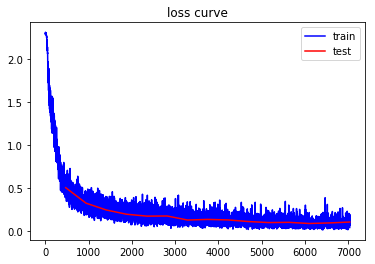

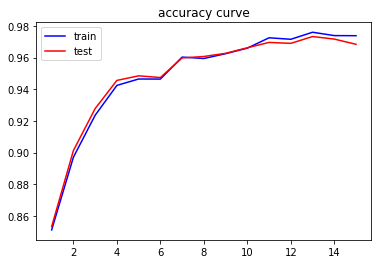

In [0]:
plt.figure()
plt.title('loss curve')
line_train, = plt.plot(training_losses, 'b', label='train')
line_test, = plt.plot([l * len(train_loader)
                      for l in range(1, len(test_losses)+1)],
                     test_losses,
                     'r', label='test')
plt.legend(handles=[line_train, line_test])

plt.figure()
plt.title('accuracy curve')
x = list(range(1, len(training_accuracies)+1))
line_train, = plt.plot(x, training_accuracies, 'b', label='train')
line_test, = plt.plot(x, test_accuracies, 'r', label='test')

plt.legend(handles=[line_train, line_test])
plt.show()